# Example optimization notebook

This notebook should be considered as being a **draft / work-in-progress**.

The first part illustrates the basics of setting up an FDFD simulation.

The second part illustrates an example of an inverse design optimization.


## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import numpy and autograd
import numpy as np
import autograd.numpy as npa

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

# Import matplotlib for plotting and visualization
import matplotlib.pylab as plt

# Add the relative path to the ceviche package
import sys
sys.path.append('../ceviche/')

# Import the ceviche package
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.utils import imarr, get_value
from ceviche.modes import get_modes

In [3]:
# Set a slightly larger figure DPI for the notebook
plt.rcParams['figure.dpi'] = 125

## Helper functions

In [4]:
def plot_re(val, outline=None):
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    
    vmax = np.abs(val).max()
    h = ax.imshow(np.real(val.T), cmap='RdBu', origin='lower left', vmin=-vmax, vmax=vmax)
    
    if outline is not None:
        ax.contour(outline.T,1,colors='k')
    
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    plt.colorbar(h, ax=ax)
    
    return ax

def plot_abs(val, outline=None):
    fig, ax = plt.subplots(1, 1, constrained_layout=True)       
    
    vmax = np.abs(val).max()
    h = ax.imshow(np.abs(val.T), cmap='magma', origin='lower left', vmin=0, vmax=vmax)
    
    if outline is not None:
        ax.contour(outline.T,1,colors='w')
    
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    plt.colorbar(h, ax=ax)
    
    return ax


## Our first simulation

First we're going to set a few variables for our simulation.

In [5]:
omega = 2 * np.pi * 200e12 # Angular frequency at 200 THz
dx = 50e-9

Nx = 100
Ny = 100

Npml = 20

epsr = np.ones((Nx, Ny))

In [6]:
source = np.zeros((Nx, Ny), dtype=np.complex)
source[Nx//2, Ny//2] = 1j

In [7]:
simulation = fdfd_ez(omega, dx, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)

/Users/iwill/miniconda3/envs/ceviche/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  
/Users/iwill/miniconda3/envs/ceviche/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


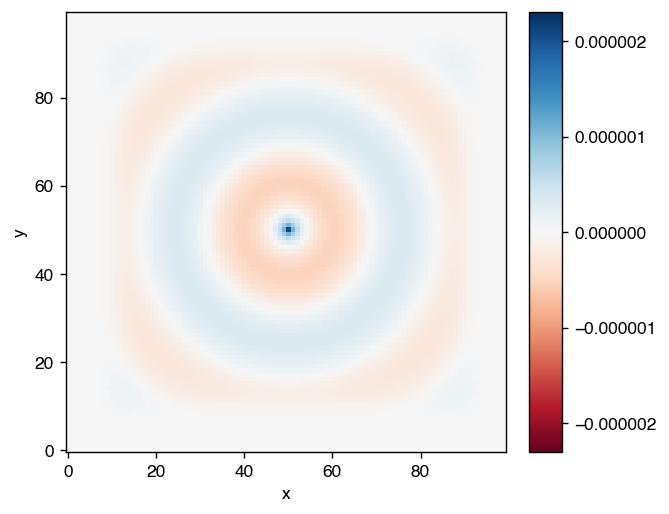

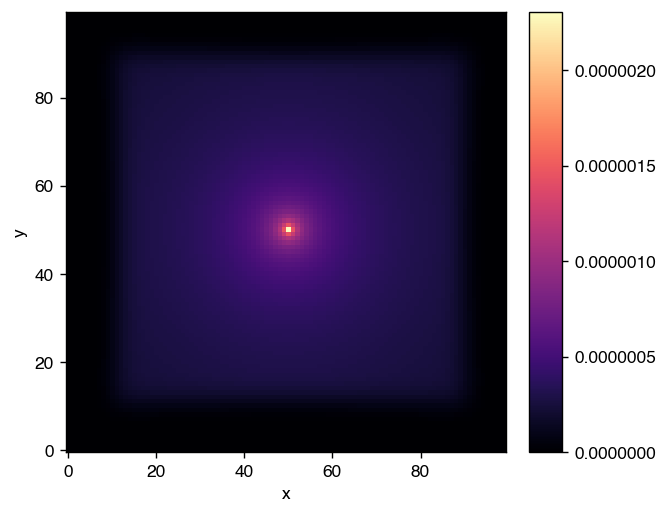

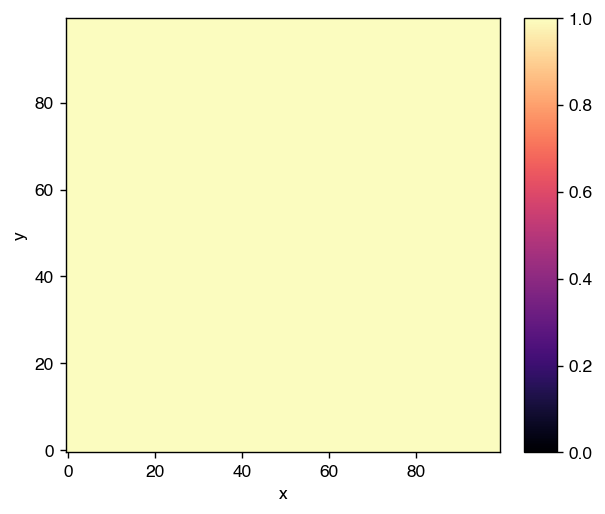

In [8]:
plot_re(Ez, epsr)
plot_abs(Ez, epsr)
plot_abs(epsr)

In [9]:
epsr[60:75, 60:75] = 12
simulation = fdfd_ez(omega, dx, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)

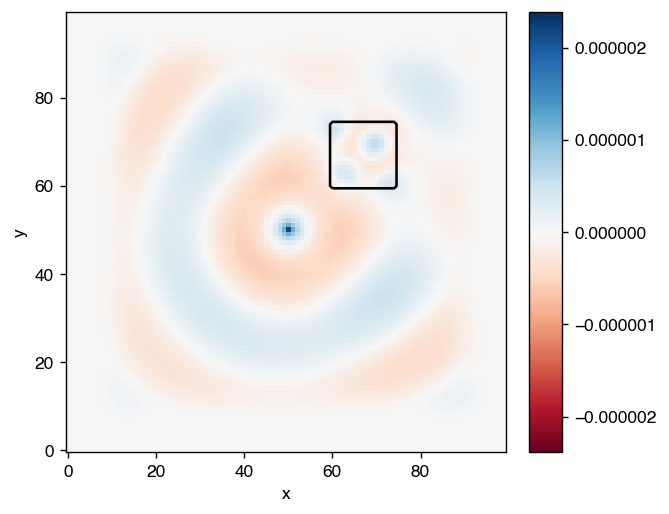

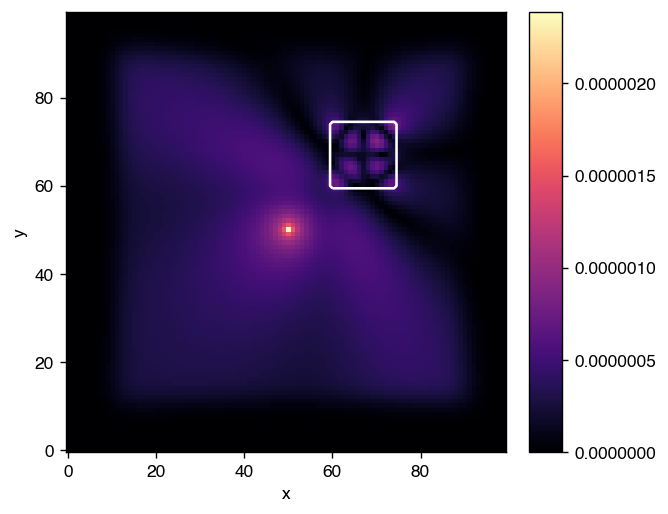

In [10]:
plot_re(Ez, epsr)
plot_abs(Ez, epsr)

## Inverse design example

Below we define the `init_domain` function to help initialize our domain. In particular it sets up (1) the input waveguides, (2) the output waveguides, (3) the extent of the design region, (4) the location (*slice*) for the input modal source, and (5) the locations (*slices*) for the output modal probes.

In [11]:
import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    output_slices = []
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    
    # Output waveguide 1
    rho[int(Nx-Npml-space)::,int(Npml+space):int(Npml+space+wg_width)] = 1
    output_slices.append(Slice(x=np.array(Nx-Npml-1), y=np.arange(int(Npml+space-space_slice), int(Npml+space+wg_width+space_slice))))
    
    # Output waveguide 2
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    output_slices.append(Slice(x=np.array(Nx-Npml-1), y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    # Output waveguide 3
    rho[int(Nx-Npml-space)::,int(Ny-Npml-space-wg_width):int(Ny-Npml-space)] = 1
    output_slices.append(Slice(x=np.array(Nx-Npml-1), y=np.arange(int(Ny-Npml-space-wg_width-space_slice), int(Ny-Npml-space+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5

    return rho, design_region, input_slice, output_slices

We will be performing our optimization in terms of a material *density*, rather than directly on the permittivity. Our permittivity will be defined as
\begin{equation*}
    \epsilon_r(x,y) = \epsilon_{\text{min}} + (\epsilon_{\text{max}} - \epsilon_{\text{min}}) \cdot \tilde\rho(x,y)
\end{equation*}
where $\tilde\rho(x,y)$ is our *projected* density given by $\tilde\rho(x,y) = P(\rho(x,y))$. Basically the projection operator, defined in the cell below, forces a material density to be between the values of 0 and 1 and encourages binarization.

In [15]:
def operator_proj(rho, eta=0.5, beta=100):
    """Density projection operator
    """
    return npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

def operator_blur(rho, radius=2):
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
    return conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]

def make_rho(rho, design_region, radius=2):
    lpf_rho = operator_blur(rho, radius=radius) * design_region
    bg_rho = rho * (design_region==0).astype(np.float)
    return bg_rho + lpf_rho

In [16]:
omega = 2 * np.pi * 200e12 # Angular frequency at 200 THz
dx = 50e-9

Nx = 100
Ny = 130
Npml = 20
 
epsr_min = 1.0
epsr_max = 12.0

# Binarization parameters
blur_radius = 3
beta = 100
eta = 0.5

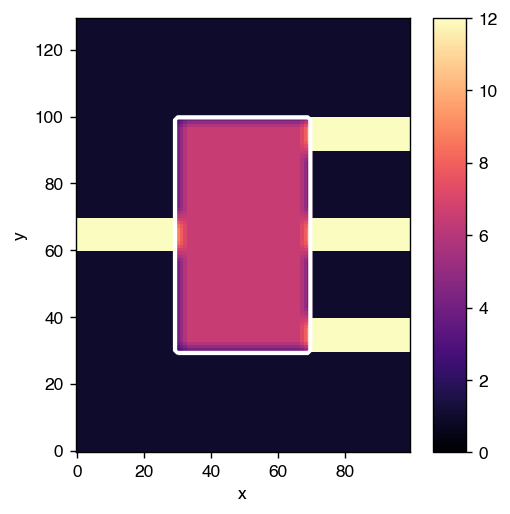

In [17]:
rho_init, design_region, input_slice, output_slices = init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=7)

epsr = epsr_min + (epsr_max-epsr_min) * make_rho(rho_init, design_region, radius=blur_radius)
plot_abs(epsr, outline=design_region)

In [18]:
source = np.zeros((Nx, Ny), dtype=np.complex)

eps_cross = epsr[input_slice.x, input_slice.y]
_, mode_in = get_modes(eps_cross, omega, dx, 0, m=1, filtering=False)
source = np.zeros((Nx, Ny), dtype=np.complex)
source[input_slice.x, input_slice.y] = mode_in.squeeze()

probes = []
for output_slice in output_slices:
    wg_cross = epsr[output_slice.x, output_slice.y]
    _, field = get_modes(wg_cross, omega, dx, 0, m=1, filtering=False)
    probe = np.zeros((Nx, Ny), dtype=np.complex)
    probe[output_slice.x, output_slice.y] = field.squeeze()
    probes.append(probe)

First, we will simulate the initial structure.

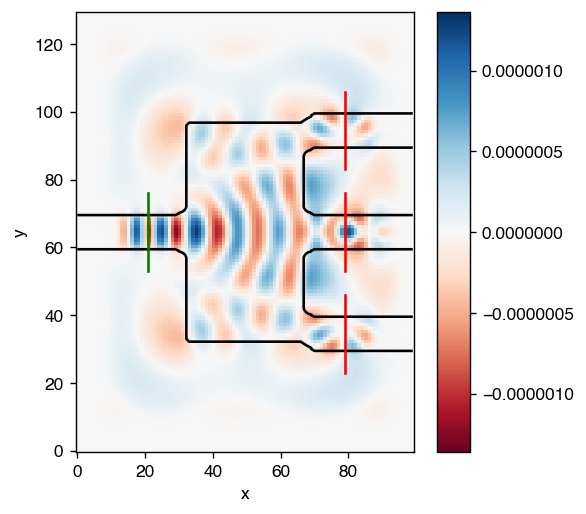

In [19]:
simulation = fdfd_ez(omega, dx, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)
ax=plot_re(Ez, outline=epsr)
ax.plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
for output_slice in output_slices:
    ax.plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')

Now we can setup and perform our optimzation.

In [20]:
def measure_modes(Ez, probe_ind=0):
    return npa.sum(npa.abs(npa.conj(Ez)*probes[probe_ind]))

def objective(rho, probe_ind=0):
    rho = rho.reshape((Nx, Ny))
    _rho = make_rho(rho, design_region, radius=blur_radius)
    epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(_rho, beta=beta, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez, probe_ind=probe_ind)

In [21]:
objective_jac = jacobian(objective, mode='reverse')

from optim import adam_optimize
(rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac, Nsteps=25, direction='max', mask=design_region.flatten(), step_size=1e-2)
rho_optimum = rho_optimum.reshape((Nx, Ny))

Epoch:   1/ 25 | Duration: 0.51 secs | Value: 9.534252e-07
Epoch:   2/ 25 | Duration: 0.52 secs | Value: 2.294341e-06
Epoch:   3/ 25 | Duration: 0.54 secs | Value: 2.270861e-06
Epoch:   4/ 25 | Duration: 0.51 secs | Value: 2.887266e-06
Epoch:   5/ 25 | Duration: 0.53 secs | Value: 2.776131e-06
Epoch:   6/ 25 | Duration: 0.51 secs | Value: 2.797707e-06
Epoch:   7/ 25 | Duration: 0.52 secs | Value: 2.887854e-06
Epoch:   8/ 25 | Duration: 0.52 secs | Value: 2.940784e-06
Epoch:   9/ 25 | Duration: 0.62 secs | Value: 2.947491e-06
Epoch:  10/ 25 | Duration: 0.60 secs | Value: 2.958495e-06
Epoch:  11/ 25 | Duration: 0.58 secs | Value: 2.987922e-06
Epoch:  12/ 25 | Duration: 0.58 secs | Value: 3.020366e-06
Epoch:  13/ 25 | Duration: 0.58 secs | Value: 3.045953e-06
Epoch:  14/ 25 | Duration: 0.58 secs | Value: 3.065342e-06
Epoch:  15/ 25 | Duration: 0.59 secs | Value: 3.079240e-06
Epoch:  16/ 25 | Duration: 0.58 secs | Value: 3.085957e-06
Epoch:  17/ 25 | Duration: 0.57 secs | Value: 3.089838e-

Finally, we simulate the final structure.

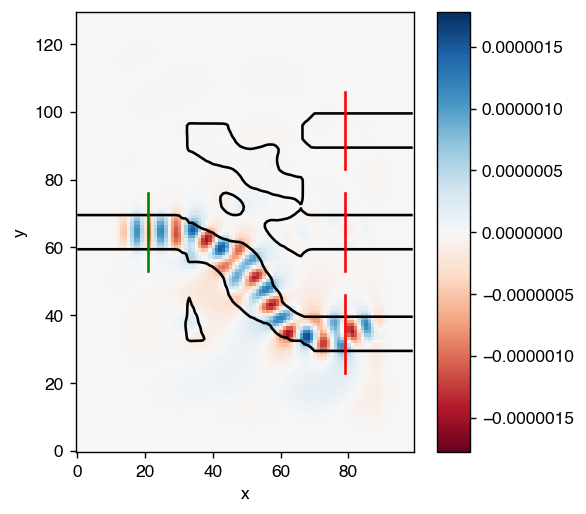

In [23]:
epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(make_rho(rho_optimum, design_region, radius=blur_radius), beta=beta, eta=eta)
simulation = fdfd_ez(omega, dx, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)
ax=plot_re(Ez, outline=epsr)
ax.plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
for output_slice in output_slices:
    ax.plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')

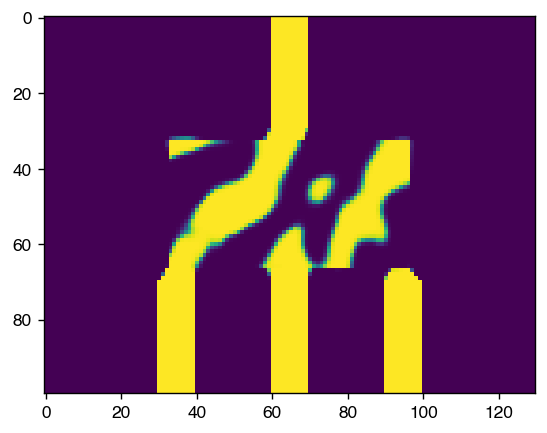

In [24]:
plt.imshow(epsr)

## TODO

* Fix the objective function to enforce mode overlap to favor the fundamental mode as the output